In [1]:
from gerrychain import updaters, Graph, constraints, GeographicPartition, proposals, tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
graph = Graph.from_file("./PA_VTD/PA_VTD.shp")
print("Loaded graph")


Loaded graph


In [3]:
print("Sample node data: ")
print(print(graph.nodes[0]))

Sample node data: 
{'boundary_node': False, 'area': 58376433.4607846, 'STATEFP10': '42', 'COUNTYFP10': '039', 'VTDST10': '60', 'GEOID10': '42039060', 'VTDI10': 'A', 'NAME10': 'CAMBRIDGE SPRINGS Voting District', 'NAMELSAD10': 'CAMBRIDGE SPRINGS Voting District', 'LSAD10': '00', 'MTFCC10': 'G5240', 'FUNCSTAT10': 'N', 'ALAND10': 2258229, 'AWATER10': 0, 'INTPTLAT10': '+41.8018353', 'INTPTLON10': '-080.0596566', 'ATG12D': 0.0, 'ATG12R': 0.0, 'GOV10D': 0.0, 'GOV10R': 0.0, 'PRES12D': 0.0, 'PRES12O': 0.0, 'PRES12R': 0.0, 'SEN10D': 0.0, 'SEN10R': 0.0, 'T16ATGD': 0.0, 'T16ATGR': 0.0, 'T16PRESD': 0.0, 'T16PRESOTH': 0.0, 'T16PRESR': 0.0, 'T16SEND': 0.0, 'T16SENR': 0.0, 'USS12D': 0.0, 'USS12R': 0.0, 'GOV': 3, 'TS': 5, 'HISP_POP': 0, 'TOT_POP': 0, 'WHITE_POP': 0, 'BLACK_POP': 0, 'NATIVE_POP': 0, 'ASIAN_POP': 0, 'F2014GOVD': 0, 'F2014GOVR': 0, '2011_PLA_1': 3, 'REMEDIAL_P': 14, '538CPCT__1': '03', '538DEM_PL': '03', '538GOP_PL': '03', '8THGRADE_1': '1', 'geometry': <shapely.geometry.polygon.Polygon 

In [4]:
my_updaters = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "BVAP": updaters.Tally("BLACK_POP", alias="BVAP"),
    "VAP": updaters.Tally("TOT_POP", alias="VAP")
}
initial_partition = GeographicPartition(graph, assignment="2011_PLA_1", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
num_districts = len(initial_partition)
dict_BVAP = {d : float(sum(
    [graph.nodes[n]["BLACK_POP"] for n in initial_partition.parts[d]]))/float(sum(
    [graph.nodes[n]["TOT_POP"] for n in initial_partition.parts[d]])) for d in initial_partition.parts}

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [5]:
BVAPS = []
counter = 0
for sample in range(0,3000):
    counter += 1
    if counter % 50 == 0:
        print(counter, end=" ")
    district = tree.bipartition_tree(graph, "TOT_POP", ideal_population, 0.02, 2)
    BVAP = sum([graph.nodes[n]["BLACK_POP"] for n in district])
    VAP = sum([graph.nodes[n]["TOT_POP"] for n in district])
    BVAPS.append(BVAP/VAP)

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750 2800 2850 2900 2950 3000 

200 200


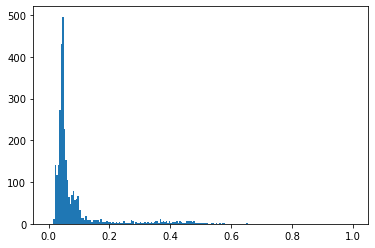

In [30]:
'''
n_bins = 200
hist = plt.hist(BVAPS, bins=np.linspace(0, 1, n_bins+1, endpoint=True))
pdf = [x/sum(BVAPS) for x in hist[0]]
import pickle 
pickle.dump( pdf, open( "pdf_PA_BVAP.p", "wb" ) )
'''

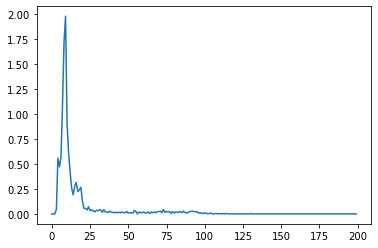

In [38]:
pdf = pickle.load(open("pdf_PA_BVAP.p", "rb"))
n_bins = len(pdf)
plt.plot(pdf)

In [31]:
class BVAP_pdf(st.rv_continuous):
    def _pdf(self,x):
        return pdf[np.digitize(x, np.linspace(0, 1, n_bins))-1]

BVAPPDF = BVAP_pdf()

In [32]:
###MCMC time
vector = list(dict_BVAP.values())
print("Starting vector: ", vector)

list_of_vector_dicts = []
counter = 0 
for step in range(0, 100000):
    [position1, position2] = np.random.choice(range(num_districts), size=2, replace=False)
    random01 = np.random.random()
    sum_of_positions = vector[position1]+vector[position2]
    proposal = [sum_of_positions*random01, sum_of_positions*(1-random01)]
    random_for_accept = np.random.random()
    alpha = BVAPPDF._pdf(proposal[0])*BVAPPDF._pdf(proposal[1])/(BVAPPDF._pdf(vector[position1])*BVAPPDF._pdf(vector[position2]))
    if (random_for_accept <= alpha):
        vector[position1] = proposal[0]
        vector[position2] = proposal[1]
    vector_dict = {x: sorted(vector)[x] for x in range(0, len(vector)) }
    counter += 1
    if counter > 1000:
        list_of_vector_dicts.append(vector_dict)
    
df = pd.DataFrame(list_of_vector_dicts)

Starting vector:  [0.04486926398104869, 0.03105268517889877, 0.028254804270462633, 0.020225113052274913, 0.036755774581212645, 0.040445916727828136, 0.045266374988477055, 0.033312124746170055, 0.07336725858724133, 0.023413005934713897, 0.030538123449518007, 0.05137649059620988, 0.04800108917936791, 0.05669159196462904, 0.2147489957847053, 0.17113362873531263, 0.5893275933166027, 0.34225497032262453]


/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [9]:
df_real = pd.read_csv("./PA_BPOP/BPOP_2000.csv", header=None)
for x in range(4000,100001,2000):
    df_real = pd.concat([df_real, pd.read_csv("./PA_BPOP/BPOP_{0}.csv".format(x), header=None)], ignore_index=True)

Done generating simulated boxplot...
Done generating real boxplot...


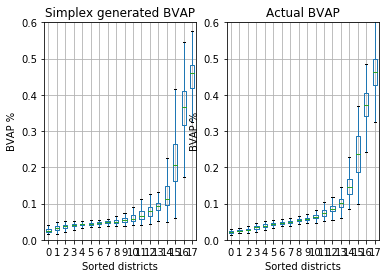

In [33]:
fig = plt.figure()
ax = plt.subplot(1,2,1)

# Draw 50% line
ax.set_title("Simplex generated BVAP")
ax.set_ylabel("BVAP %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 0.6)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Draw boxplot
bp = df.boxplot(ax=ax, showfliers=False)
print("Done generating simulated boxplot...")

ax2 = plt.subplot(1,2,2)
bp_real = df_real.boxplot(ax=ax2, showfliers=False)
print("Done generating real boxplot...")
ax2.set_title("Actual BVAP")
ax2.set_ylabel("BVAP %")
ax2.set_xlabel("Sorted districts")
ax2.set_ylim(0, 0.6)
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])


# Annotate


plt.show()
fig.savefig("Comparing_simplex_to_actual_PA.png")